In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

import re
import preprocessor as p
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.utils import plot_model, to_categorical

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = '{:0.2f}'.format

In [3]:
# FX過去のデータ
df = pd.read_csv("FX_MA_5days.csv")
df.head()

,time,open,high,low,close,5mean,target
0,2015-01-08 07:00:00,119.24,119.96,119.16,119.66,119.49,0
1,2015-01-09 07:00:00,119.69,119.88,118.42,118.54,119.10,0
2,2015-01-12 07:00:00,118.34,119.32,118.10,118.35,118.84,0
3,2015-01-13 07:00:00,118.36,118.85,117.54,117.92,118.75,0
4,2015-01-14 07:00:00,117.92,117.96,116.07,117.33,118.36,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 7 columns):
time      515 non-null object
open      515 non-null float64
high      515 non-null float64
low       515 non-null float64
close     515 non-null float64
5mean     515 non-null float64
target    515 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 28.3+ KB


In [5]:
df['target'].value_counts()

1    268
0    247
Name: target, dtype: int64

In [6]:
# 時間表記スライシング
def timechange(time):
    time = "".join(str(time)[:10])
    return time

In [7]:
df['time'] = df['time'].apply(lambda x: timechange(x))
df = df.rename(columns={'time':'date'})
df.head()

,date,open,high,low,close,5mean,target
0,2015-01-08,119.24,119.96,119.16,119.66,119.49,0
1,2015-01-09,119.69,119.88,118.42,118.54,119.10,0
2,2015-01-12,118.34,119.32,118.10,118.35,118.84,0
3,2015-01-13,118.36,118.85,117.54,117.92,118.75,0
4,2015-01-14,117.92,117.96,116.07,117.33,118.36,0


In [8]:
#　Twitterデータ取得
tweet = pd.read_csv('trumptweep2015~.csv')
del tweet['Unnamed: 0']
tweet.head()

,date,tweet
0,2015-07-17,RT @Krause_Don: @realDonaldTrump You have bee...
1,2015-07-18,Via @fitsnews: Donald Trump: John McCain Is A...
2,2015-07-19,The Republican Party must get tougher and sma...
3,2015-07-20,RT @DanScavino: #Breaking\n#ABC #NEWS ۢ #Wash...
4,2015-07-21,My response to the failing Des Moines Registe...


In [9]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 2 columns):
date     478 non-null object
tweet    473 non-null object
dtypes: object(2)
memory usage: 7.6+ KB


In [10]:
#　右にJoinする
data = pd.merge(df, tweet, on='date', how='right')
data = data.dropna()
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,RT @Krause_Don: @realDonaldTrump You have bee...
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,RT @DanScavino: #Breaking\n#ABC #NEWS ۢ #Wash...
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,My response to the failing Des Moines Registe...
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,"RT @CNNPolitics: .@realdonaldtrump: ""The poli..."
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,RT @DRUDGE_REPORT: I think Ill get the nomina...


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 341
Data columns (total 8 columns):
date      339 non-null object
open      339 non-null float64
high      339 non-null float64
low       339 non-null float64
close     339 non-null float64
5mean     339 non-null float64
target    339 non-null float64
tweet     339 non-null object
dtypes: float64(6), object(2)
memory usage: 23.8+ KB


In [12]:
def remove_punctuation(text):
    no_punc = "".join([x for x in text if x not in string.punctuation])
    return no_punc

In [13]:
data['tweet'] = data['tweet'].apply(lambda x: remove_punctuation(x))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,RT KrauseDon realDonaldTrump You have been a ...
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,RT DanScavino Breaking\nABC NEWS ۢ Washington...
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,My response to the failing Des Moines Registe...
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,RT CNNPolitics realdonaldtrump The politician...
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,RT DRUDGEREPORT I think Ill get the nominatio...


In [14]:
# instantiate tokenizer
tokenizer = RegexpTokenizer(r'\w+')
data['tweet'] = data['tweet'].apply(lambda x: tokenizer.tokenize(x.lower()))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,"[rt, krausedon, realdonaldtrump, you, have, be..."
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,"[rt, danscavino, breaking, abc, news, washingt..."
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,"[my, response, to, the, failing, des, moines, ..."
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,"[rt, cnnpolitics, realdonaldtrump, the, politi..."
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,"[rt, drudgereport, i, think, ill, get, the, no..."


In [15]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [16]:
data['tweet'] = data['tweet'].apply(lambda x: remove_stopwords(x))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,"[rt, krausedon, realdonaldtrump, breath, fresh..."
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,"[rt, danscavino, breaking, abc, news, washingt..."
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,"[response, failing, des, moines, register, ult..."
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,"[rt, cnnpolitics, realdonaldtrump, politicians..."
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,"[rt, drudgereport, think, ill, get, nomination..."


In [17]:
# instantiate lemmatizer
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(x) for x in text]
    return lem_text

In [18]:
data['tweet'] = data['tweet'].apply(lambda x: word_lemmatizer(x))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,"[rt, krausedon, realdonaldtrump, breath, fresh..."
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,"[rt, danscavino, breaking, abc, news, washingt..."
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,"[response, failing, de, moines, register, ultr..."
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,"[rt, cnnpolitics, realdonaldtrump, politician,..."
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,"[rt, drudgereport, think, ill, get, nomination..."


In [19]:
# instantiate stemmer
stemmer = PorterStemmer()
def word_stemmer(text):
    stem_txt = " ".join([stemmer.stem(x) for x in text])
    return stem_txt

In [20]:
data['tweet'] = data['tweet'].apply(lambda x: word_stemmer(x))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,rt krausedon realdonaldtrump breath fresh air ...
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,rt danscavino break abc news washington releas...
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,respons fail de moin regist ultra liber paper ...
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,rt cnnpolit realdonaldtrump politician go dest...
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,rt drudgereport think ill get nomin httptco9ug...


In [21]:
def include_bag(text):
    boolean = False
    # bagのデータを取得
    FX_word = pd.read_csv('../NLP/bag_of_words.csv')
    FX_word['word'] = FX_word['Unnamed: 0']
    del FX_word['Unnamed: 0']
    #　意図的にFXで使用する単語のリストを追加する
    new = ['japan', 'usd', 'jpy', 'abe', 'doller', 'yen', 'fx']
    fx_word = list(FX_word.word) + new
    #　文章にbagの単語があればTrueなければFalesを返す
    text = text.split()
    for x in range(len(text)):
        if text[x] in fx_word:
            boolean = True
    return boolean

In [22]:
data['FX_word'] = data['tweet'].apply(lambda x: include_bag(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,rt krausedon realdonaldtrump breath fresh air ...,True
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,rt danscavino break abc news washington releas...,False
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,respons fail de moin regist ultra liber paper ...,False
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,rt cnnpolit realdonaldtrump politician go dest...,True
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,rt drudgereport think ill get nomin httptco9ug...,False


In [23]:
def pos_check(text):
    sid = SIA()
    ss = sid.polarity_scores(text)
    return ss['pos']

In [24]:
data['pos'] = data['tweet'].apply(lambda x: pos_check(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,rt krausedon realdonaldtrump breath fresh air ...,True,0.19
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,rt danscavino break abc news washington releas...,False,0.19
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,respons fail de moin regist ultra liber paper ...,False,0.21
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,rt cnnpolit realdonaldtrump politician go dest...,True,0.19
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,rt drudgereport think ill get nomin httptco9ug...,False,0.21


In [25]:
def neg_check(text):
    sid = SIA()
    ss = sid.polarity_scores(text)
    return ss['neg']

In [26]:
data['neg'] = data['tweet'].apply(lambda x: neg_check(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos,neg
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,rt krausedon realdonaldtrump breath fresh air ...,True,0.19,0.11
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,rt danscavino break abc news washington releas...,False,0.19,0.04
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,respons fail de moin regist ultra liber paper ...,False,0.21,0.08
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,rt cnnpolit realdonaldtrump politician go dest...,True,0.19,0.09
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,rt drudgereport think ill get nomin httptco9ug...,False,0.21,0.07


In [27]:
def neu_check(text):
    sid = SIA()
    ss = sid.polarity_scores(text)
    return ss['neu']

In [28]:
data['neu'] = data['tweet'].apply(lambda x: neu_check(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos,neg,neu
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,rt krausedon realdonaldtrump breath fresh air ...,True,0.19,0.11,0.70
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,rt danscavino break abc news washington releas...,False,0.19,0.04,0.76
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,respons fail de moin regist ultra liber paper ...,False,0.21,0.08,0.71
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,rt cnnpolit realdonaldtrump politician go dest...,True,0.19,0.09,0.72
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,rt drudgereport think ill get nomin httptco9ug...,False,0.21,0.07,0.72


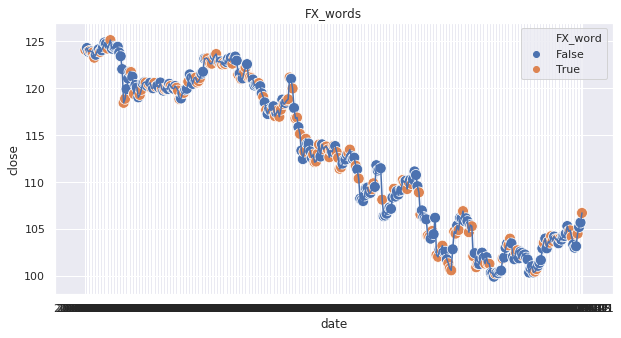

In [29]:
sns.set()
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data['date'], data['close']).set_title("FX_words")
sns.scatterplot(data['date'], data['close'],s = 120, hue=data['FX_word'])

In [30]:
senti = []
for i in range(len(data)):
    senti_tweet = 'neu_tweet'
    if data.iloc[i]['pos'] >= 0.2 and data.iloc[i]['pos'] > data.iloc[i]['neg']:
        senti_tweet = 'pos_tweet'
    elif data.iloc[i]['neg'] >= 0.18 and data.iloc[i]['pos'] < data.iloc[i]['neg']:
        senti_tweet = 'neg_tweet'
    senti.append(senti_tweet)

In [31]:
data['senti_tweet'] = senti
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos,neg,neu,senti_tweet
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,rt krausedon realdonaldtrump breath fresh air ...,True,0.19,0.11,0.70,neu_tweet
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,rt danscavino break abc news washington releas...,False,0.19,0.04,0.76,neu_tweet
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,respons fail de moin regist ultra liber paper ...,False,0.21,0.08,0.71,pos_tweet
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,rt cnnpolit realdonaldtrump politician go dest...,True,0.19,0.09,0.72,neu_tweet
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,rt drudgereport think ill get nomin httptco9ug...,False,0.21,0.07,0.72,pos_tweet


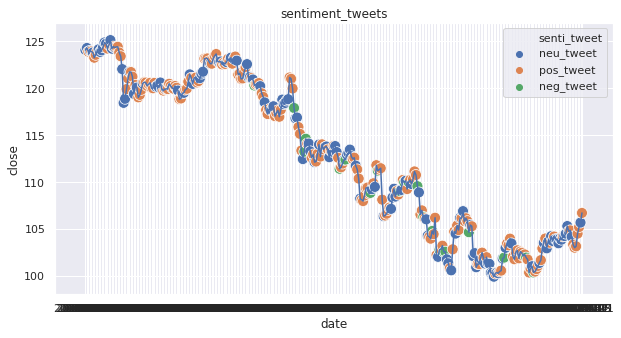

In [32]:
sns.set()
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data['date'], data['close']).set_title("sentiment_tweets")
sns.scatterplot(data['date'], data['close'],s = 120, hue=data['senti_tweet'])
fig.savefig('FX_sentiment_tweet.png')

In [33]:
# ここでTweetの感情を基準にラベルを変えている
data['target'][data['senti_tweet'] == 'pos_tweet'] = 2.00
data['target'][data['senti_tweet'] == 'neu_tweet'] = 1.00
data['target'][data['senti_tweet'] == 'neg_tweet'] = 0.00
data['target'].value_counts()

/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

2.00    191
1.00    127
0.00     21
Name: target, dtype: int64

In [34]:
def FX_words_to_number(boolean):
    if boolean == True:   # FXの言葉が含まれている
        return 0.00
    else:   # FXの言葉が含まれていない
        return 1.00

In [35]:
def senti_tweets_to_cotegori(categori):
    if categori == "pos_tweet":   #肯定的Tweet
        return 0.00
    elif categori == "neu_tweet":    #普通Tweet
        return 1.00
    else:    #否定的Tweet
        return 2.00

In [36]:
#　前処理　＋　データを数字化
#tweets = data['tweet']
#del data['tweet']
data['FX_word'] = data['FX_word'].apply(lambda x: FX_words_to_number(x))
data['senti_tweet'] = data['senti_tweet'].apply(lambda x: senti_tweets_to_cotegori(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos,neg,neu,senti_tweet
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,rt krausedon realdonaldtrump breath fresh air ...,0.00,0.19,0.11,0.70,1.00
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,rt danscavino break abc news washington releas...,1.00,0.19,0.04,0.76,1.00
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,2.00,respons fail de moin regist ultra liber paper ...,1.00,0.21,0.08,0.71,0.00
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,rt cnnpolit realdonaldtrump politician go dest...,0.00,0.19,0.09,0.72,1.00
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,2.00,rt drudgereport think ill get nomin httptco9ug...,1.00,0.21,0.07,0.72,0.00


In [37]:
# columnの並び替え
data = data.ix[:, ['date','open','high','low','close','5mean',
            'FX_word','pos','neg','neu','senti_tweet','target']]
data.head()

/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,date,open,high,low,close,5mean,FX_word,pos,neg,neu,senti_tweet,target
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,0.00,0.19,0.11,0.70,1.00,1.00
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,0.19,0.04,0.76,1.00,1.00
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,0.21,0.08,0.71,0.00,2.00
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,0.00,0.19,0.09,0.72,1.00,1.00
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,1.00,0.21,0.07,0.72,0.00,2.00


In [38]:
#　全体を8:2で等割
split_data = '2016-08-05'
train, test = data[data['date'] < split_data], data[data['date'] >= split_data]

In [39]:
train = train.set_index('date')
test = test.set_index('date')

In [40]:
X_train = train.iloc[:,:-6]
Y_train = train['target']

X_test = test.iloc[:,:-6]
Y_test = test['target']

In [41]:
X_train = X_train.as_matrix()
print("Data len: ",len(X_train))

X_test = X_test.as_matrix()
print("Data len: ",len(X_test))

# 正規化
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)

ms = MinMaxScaler()
X_test = ms.fit_transform(X_test)

Data len:  269
Data len:  70


/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [42]:
Y_train = np.array(Y_train, dtype=np.int64)
print("Y_train Target len: ",len(Y_train))

Y_test = np.array(Y_test, dtype=np.int64)
print("Y_train Target len: ",len(Y_test))

Y_train Target len:  269
Y_train Target len:  70


In [43]:
maxlen = 5
dataTrain = []
targetTrain = []
for i in range(0, len(X_train) - maxlen):
    dataTrain.append(X_train[i: i + maxlen])
    targetTrain.append(Y_train[i + maxlen])

dataTest = []
targetTest = []
for i in range(0, len(X_test) - maxlen):
    dataTest.append(X_test[i: i + maxlen])
    targetTest.append(Y_test[i + maxlen])

In [44]:
X_train = np.array(dataTrain)
Y_train = np.array(targetTrain)

X_test = np.array(dataTest)
Y_test = np.array(targetTest)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(264, 5, 5)
(264,)
(65, 5, 5)
(65,)


In [45]:
#Y_train = Y_train.reshape(len(Y_train), 1)
#Y_test = Y_test.reshape(len(Y_test), 1)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [46]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(264, 5, 5)
(264, 3)
(65, 5, 5)
(65, 3)


In [47]:
'''
モデル設定
'''
length_of_sequence = X_train.shape[1]  # 入力層 = 5
out_neurons = 3                        # 出力層 = 3
n_hidden = 64                          # 隠れ層 = 100

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, 5), return_sequences=False))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(out_neurons))
model.add(Activation("softmax"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [48]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, metrics=['acc'])

In [49]:
#plot_model(model, to_file='model.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
__________

In [50]:
# コールバック指定（https://qiita.com/yukiB/items/f45f0f71bc9739830002）
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='auto', patience=20)
history = model.fit(X_train, Y_train,
                  batch_size = 1, # 論文で使われるのが1, 32, 128, 256, 512
                  epochs=200,
                  validation_split=0.2,
                  callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 211 samples, validate on 53 samples
Epoch 1/200
211/211 [==============================] - 2s 11ms/step - loss: 0.8485 - acc: 0.5166 - val_loss: 1.0461 - val_acc: 0.5283
Epoch 2/200
211/211 [==============================] - 1s 5ms/step - loss: 0.8222 - acc: 0.5687 - val_loss: 1.0321 - val_acc: 0.5283
Epoch 3/200
211/211 [==============================] - 1s 5ms/step - loss: 0.8291 - acc: 0.5592 - val_loss: 1.0368 - val_acc: 0.5283
Epoch 4/200
211/211 [==============================] - 1s 5ms/step - loss: 0.8358 - acc: 0.5924 - val_loss: 1.0545 - val_acc: 0.5283
Epoch 5/200
211/211 [==============================] - 1s 5ms/step - loss: 0.8276 - acc: 0.5782 - val_loss: 1.0314 - val_acc: 0.5283
Epoch 6/200
211/211 [==============================] - 1s 5ms/step - loss: 0.8361 - acc: 0.5782 - val_loss: 1.0341 - val_acc: 0.5283
Epoch 7/200
211/211 [==============================] - 1s 6ms/

211/211 [==============================] - 1s 5ms/step - loss: 0.8107 - acc: 0.5877 - val_loss: 1.0279 - val_acc: 0.5283


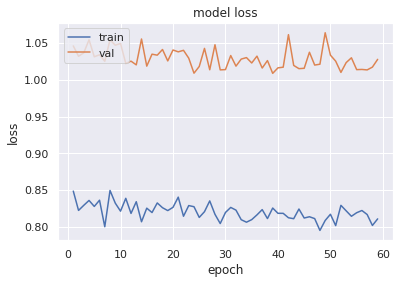

In [51]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('FinalMA5loss.png')
plt.show()

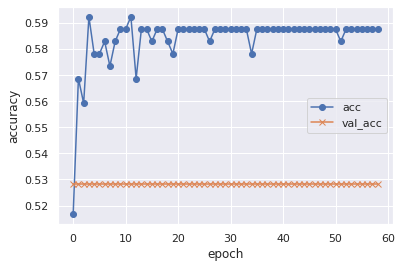

In [52]:
#acc, val_accのプロット
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.savefig('FinalMA5acc.png')
plt.show()

In [53]:
print("Test accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

65/65 [==============================] - 0s 132us/step
Test accuracy: 0.5231


In [54]:
predict_classes = model.predict_classes(X_test)

In [55]:
Y_test = np.array([np.argmax(x) for x in Y_test])

In [56]:
pd.crosstab(Y_test, predict_classes, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,2,All
True,,
0,3,3
1,28,28
2,34,34
All,65,65
